In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Remove this if you have matplotlib >= 3.2.0
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm

import numpy as np
import pandas as pd
import astropy.units as u
from tqdm import tqdm
from astropy.io import fits
from astropy.coordinates import Angle
from gammapy.spectrum import SensitivityEstimator, CountsSpectrum
from gammapy.irf import EffectiveAreaTable2D, Background2D, PSF3D, EnergyDispersion2D, Background3D, EnergyDependentMultiGaussPSF
from scipy.ndimage import gaussian_filter
import fact.io

In [2]:
path = '../cta_irf.fits'

energy_reco = np.logspace(-2, 2, 20) * u.TeV
offsets = np.linspace(0, 6, 7) * u.deg

Text(0.5, 0, 'Reconstructed Energy / TeV')

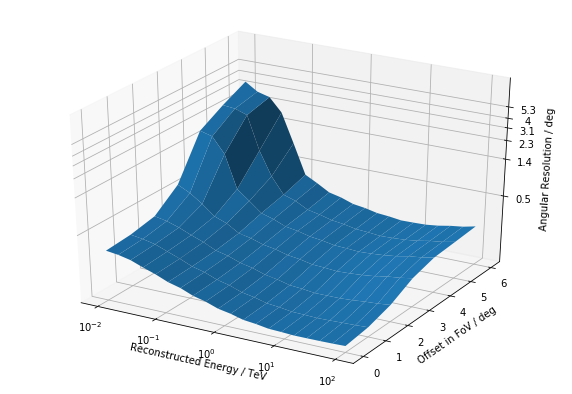

In [88]:
fig = plt.figure(figsize=(10, 7),)
ax = fig.add_subplot(111, projection='3d')
psf = PSF3D.read(path, hdu="PSF")

d = np.linspace(0.1, 4, 10)[1::2]
ticks = np.log10(d)
ticks = np.append(ticks, 1 + ticks)

X, Y = np.meshgrid(energy_reco, offsets)
Z = []
for x in energy_reco:
    zs = psf.containment_radius(x, offsets, fraction=0.68)
    Z.append(zs)

Z = np.vstack(Z).T
surf = ax.plot_surface(np.log10(X.to_value('TeV')), Y, np.log10(Z), linewidth=1, antialiased=True)

def log_tick_formatter(val, pos=None):
    if float(val).is_integer():
        return f'$10^{{{int(val)}}}$'

def log_scale_formatter(val, pos=None):
    pos = np.round((10**val), decimals=1)
    if float(pos).is_integer():
        pos = pos.astype(np.int)
    return pos

ax.xaxis.set_major_locator(mticker.FixedLocator([-2, -1, 0, 1, 2 ]))
ax.zaxis.set_major_locator(mticker.FixedLocator(ticks))
# ax.xaxis.set_major_locator(mticker.FixedLocator(np.linspace(-2, 2, 41)))

# ax.xaxis.set_minor_locator(mticker.FixedLocator(np.linspace(-2, 2, 41)))
ax.zaxis.set_major_formatter(mticker.FuncFormatter(log_scale_formatter))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.set_zlim([-1 ,1])
ax.set_ylabel('Offset in FoV / deg')
ax.set_zlabel('Angular Resolution / deg')
ax.set_xlabel('Reconstructed Energy / TeV')

# surf.set_array(10**surf.get_array())
# fig.colorbar(surf, shrink=0.5, aspect=10, )
# surf.set_array(np.log10(surf.get_array()))
# ax.zaxis.set_major_formatter(mticker.LogFormatterMathtext())
# ax.w_xaxis._axinfo
# ax.w_xaxis._axinfo.update({'tickdir':1})

In [89]:
def bin_center(bin_edges):
    center = np.sign(bin_edges[:-1]) * np.sqrt(bin_edges[:-1] * bin_edges[1:])
    return center

(-4, 1)

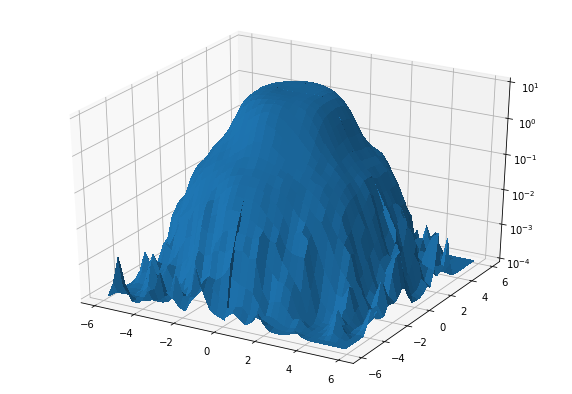

In [151]:
fig = plt.figure(figsize=(10, 7),)
ax = fig.add_subplot(111, projection='3d')

bkg3d = Background3D.read(path, hdu="BACKGROUND")

offset_centers = bin_center(bkg3d.data.axes[1].bins)
data = bkg3d.data.data.sum(axis=0).value

m = (data == 0)
data[m] = np.nan
log_data =  np.log10(data)
m = ~np.isfinite(log_data)
log_data[m] = log_data[~m].min()

X, Y = np.meshgrid(offset_centers, offset_centers)

vmin, vmax = -4, log_data.max()
log_data = np.clip(log_data, vmin, vmax)
surf = ax.plot_surface(X, Y, gaussian_filter(log_data, sigma=0.7),  vmin=vmin, vmax=vmax, antialiased=False)
# ax.plot_wireframe(X, Y, gaussian_filter(log_data, sigma=0.7), cstride=2, rstride=2,   antialiased=True)


ax.zaxis.set_major_locator(mticker.FixedLocator([-4, -3, -2, -1, 0, 1,]))
ax.zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.set_zlim([-4 ,1])


(7, 19) (7, 19) (7, 19) 133 m2


Text(0.5, 0, 'Reconstructed Energy / TeV')

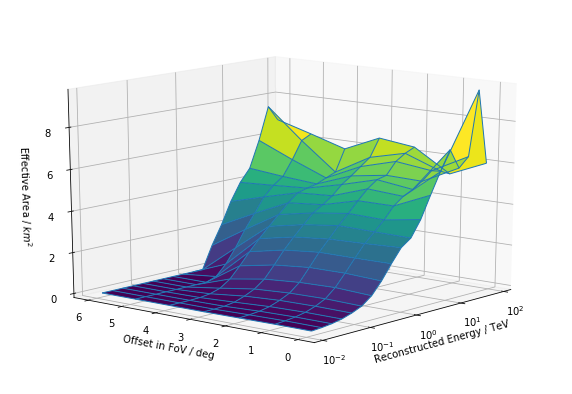

In [145]:
fig = plt.figure(figsize=(10, 7),)
ax = fig.add_subplot(111, projection='3d')

aeff = EffectiveAreaTable2D.read(path, hdu="EFFECTIVE AREA")

d = np.linspace(0.1, 4, 10)[1::2]
ticks = np.log10(d)
ticks = np.append(ticks, 1 + ticks)

X, Y = np.meshgrid(bin_center(energy_reco), offsets)

Z = []
for offset in offsets: 
    t = aeff.to_effective_area_table(offset=offset, energy=energy_reco)
    Z.append(t.data.data)

Z = np.vstack(Z).value * u.m**2
print(X.shape, Y.shape, Z.shape, np.isfinite(Z).sum(), Z.unit)
surf = ax.plot_surface(np.log10(X.to_value('TeV')), Y, Z.to('km2'), cmap='viridis', linewidth=1, antialiased=True)
surf = ax.plot_wireframe(np.log10(X.to_value('TeV')), Y, Z.to('km2'), linewidth=1, antialiased=True)

ax.xaxis.set_major_locator(mticker.FixedLocator([-2, -1, 0, 1, 2 ]))
# ax.zaxis.set_major_locator(mticker.FixedLocator(ticks))
# ax.xaxis.set_major_locator(mticker.FixedLocator(np.linspace(-2, 2, 41)))

# ax.xaxis.set_minor_locator(mticker.FixedLocator(np.linspace(-2, 2, 41)))
# ax.zaxis.set_major_formatter(mticker.FuncFormatter(log_scale_formatter))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.view_init(15, -140)
# ax.set_zlim([-1 ,1])
ax.set_ylabel('Offset in FoV / deg')
ax.set_zlabel('Effective Area / $km^2$')
ax.set_xlabel('Reconstructed Energy / TeV')


In [92]:
erf = edisp.to_energy_dispersion('1 deg')
erf

In [93]:
erf.get_resolution(energy_reco)

<Quantity [0.28114735, 0.21721863, 0.2478772 , 0.32628573, 0.23523678,
           0.21233894, 0.25659947, 0.19497454, 0.16390526, 0.13793196,
           0.14159569, 0.15655743, 0.15226743, 0.20068772, 0.16287657,
           0.22623016, 0.23933604, 0.32455848, 0.23340166, 0.19848716]>

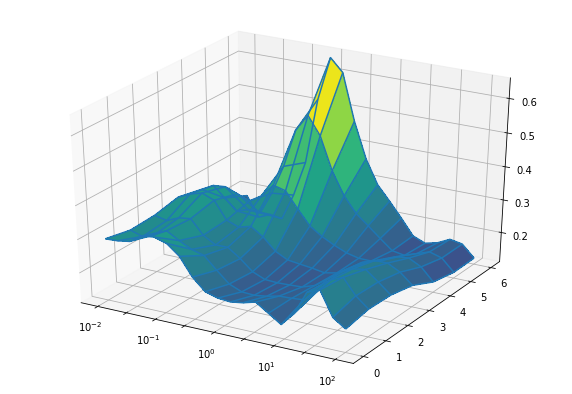

In [143]:
fig = plt.figure(figsize=(10, 7),)
ax = fig.add_subplot(111, projection='3d')

edisp = EnergyDispersion2D.read(path, hdu="ENERGY DISPERSION")

Z = []
offset_centers = bin_center(bkg3d.data.axes[1].bins)
for offset in offsets:
    erf = edisp.to_energy_dispersion(offset)
    zs  = erf.get_resolution(energy_reco).value
    Z.append(zs)

    
X, Y = np.meshgrid(energy_reco, offsets)
Z = np.vstack(Z)
mask = ~np.isfinite(Z)
Z[mask] = np.nanmean(Z)
Z = gaussian_filter(Z, sigma=0.8)
# print(X.shape, Y.shape, Z.shape)
surf = ax.plot_surface(np.log10(X.to_value('TeV')), Y, Z, cmap='viridis', vmin=0, vmax=np.nanpercentile(Z, 99), antialiased=False, rstride=1, cstride=1)
ax.plot_wireframe(np.log10(X.to_value('TeV')), Y, Z,  antialiased=True)


# ax.zaxis.set_major_locator(mticker.FixedLocator([-4, -3, -2, -1, 0, 1,]))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
# ax.set_zlim([-4 ,1])